# CIROH Developers Conference: Hydrological Applications of ML
## CNNs for Predicting Daily Orographic Precipitation Gradients for Atmospheric Downscaling

### First, lets finalize our CNN for predicting OPGs

##### Load in python libraries.

In [51]:
# Machine learning library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D,
                          Dense,
                          ReLU,LeakyReLU,
                          BatchNormalization, 
                          MaxPooling2D, 
                          Dropout,
                          Flatten)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import nclcmaps as ncm
import cartopy.crs as ccrs

##### Load in atmospheric and OPG data. Standardize the variables. Create atmospheric variable.

In [71]:
# load in the atmospheric data
path      = "../datasets/era5_atmos/"
IVT       = xr.open_dataset(f"{path}IVT_sfc.nc")
precip    = xr.open_dataset(f"{path}precip_sfc.nc")*1000
temp700   = xr.open_dataset(f"{path}temp_700.nc")-273.15
uwinds700 = xr.open_dataset(f"{path}uwnd_700.nc")
vwinds700 = xr.open_dataset(f"{path}vwnd_700.nc")
hgt500    = xr.open_dataset(f"{path}hgt_500.nc")/9.81

latitudes  = hgt500['latitude']
longitudes = hgt500['longitude']

# load in the OPGs
path = "../datasets/facets_and_opgs/"
opg  = pd.read_csv(f"{path}winter_northernUT_opg.csv", index_col=0)
facet_list = opg.columns.values
opg = opg.values

# Standardize
IVT_       = (IVT - IVT.mean(dim="time")) / IVT.std(dim="time")
precip_    = (precip - precip.mean(dim="time")) / precip.std(dim="time")
temp700_   = (temp700 - temp700.mean(dim="time")) / temp700.std(dim="time")
uwinds700_ = (uwinds700 - uwinds700.mean(dim="time")) / uwinds700.std(dim="time")
vwinds700_ = (vwinds700 - vwinds700.mean(dim="time")) / vwinds700.std(dim="time")
hgt500_    = (hgt500 - hgt500.mean(dim="time")) / hgt500.std(dim="time")

opg_mean = np.nanmean(opg, axis=0)
opg_std  = np.nanstd(opg, axis=0)
opg = (opg - opg_mean) / opg_std
opg[np.isnan(opg)] = 0

# Combine the atmospheric data into one array
atmos = np.concatenate((IVT_.IVT.values[...,np.newaxis], 
                        precip_.precip.values[...,np.newaxis],
                        temp700_.temp.values[...,np.newaxis],
                        uwinds700_.uwnd.values[...,np.newaxis],
                        vwinds700_.vwnd.values[...,np.newaxis],
                        hgt500_.hgt.values[...,np.newaxis]), axis=3)

##### Create varaiables containing size of atmospheric 'images'.

In [13]:
latitude  = 19
longitude = 27
channels  = 6

##### Shuffle observation days and split the data into training, testing, and validation subsets.

In [14]:
np.random.seed(42)
rand_ind = np.random.permutation(np.arange(np.shape(atmos)[0]))

train_atmos = atmos[rand_ind[:1896], ...]
test_atmos  = atmos[rand_ind[1896:2302], ...]
val_atmos   = atmos[rand_ind[2302:], ...]

train_opg = opg[rand_ind[:1896], ...]
test_opg  = opg[rand_ind[1896:2302], ...]
val_opg   = opg[rand_ind[2302:], ...]

print(np.shape(test_atmos))

(406, 19, 27, 6)


##### Define the training batch size (i.e., the number of images to import for any update step) and the CNN stucture.

In [15]:
batch_size = 32

def create_model():
    model = Sequential([  
        Input(shape=(latitude, longitude, channels), name='input'),
        Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', name='conv2D_01'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', name='conv2D_02'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(.25),
        Flatten(),
        Dense(units = 100, activation = 'relu'),
        Dense(units = 100, activation = 'relu'),
        Dropout(.25),
        Dense(units = len(facet_list))
    ])
    return model

##### Create and compile the CNN, then fit to the training subset.

In [16]:
model = create_model()
model.summary()

model.compile(loss = 'mean_squared_error', 
              metrics = ["mean_absolute_error"], 
              optimizer = RMSprop(learning_rate=1e-4))

callback = [EarlyStopping(monitor='val_loss', patience=5, mode='min')]
epochs = 80
hist = model.fit(train_atmos, train_opg, # training data
                  batch_size = batch_size,
                  epochs = epochs,                        # epochs
                  validation_data = (val_atmos, val_opg), # validation data
                  callbacks=[callback],                   # patience
                  verbose = 1)                           # print progress

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2D_01 (Conv2D)              │ (None, 19, 27, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 13, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2D_02 (Conv2D)              │ (None, 9, 13, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 13, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,678 (373.74 KB)

 Trainable params: 95,614 (373.49 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5544 - mean_absolute_error: 0.9056 - val_loss: 0.5077 - val_mean_absolute_error: 0.3855
Epoch 2/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7696 - mean_absolute_error: 0.6058 - val_loss: 0.4921 - val_mean_absolute_error: 0.3725
Epoch 3/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6043 - mean_absolute_error: 0.5116 - val_loss: 0.4791 - val_mean_absolute_error: 0.3668
Epoch 4/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5347 - mean_absolute_error: 0.4621 - val_loss: 0.4619 - val_mean_absolute_error: 0.3616
Epoch 5/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4795 - mean_absolute_error: 0.4268 - val_loss: 0.4443 - val_mean_absolute_error: 0.3580
Epoch 6/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4488 - mean_absolute_error: 0.4021 - val_loss: 0.4306 - val_mean_absolute_error: 0.3551
Epoch 7/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4322 - mean_absolute_error: 0.3925 - val_loss: 0.421

### Initial Evaluation of the CNN

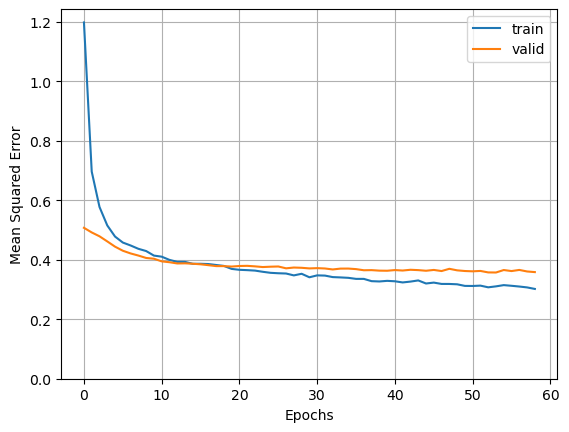

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


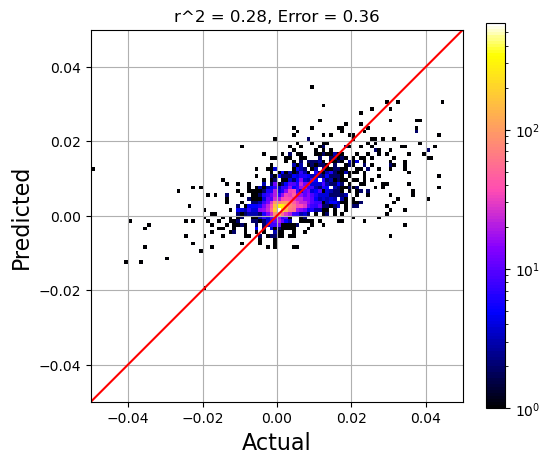

In [17]:
def plot_loss(hist_obs):
    plt.plot(hist_obs.history['loss'], label='train')
    plt.plot(hist_obs.history['val_loss'], label='valid')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_act_pred(modelx, hist_obs):
    # Using our fitted model, predict OPGs from the testing subset.
    predicted = modelx.predict(test_atmos)

    # set zero OPGs to nan
    actual = test_opg
    actual[actual==0] = np.nan
    predicted[predicted==0] = np.nan
    
    # Convert from standardized OPG to mm/m OPG
    actual    = (test_opg * opg_std) + opg_mean
    predicted = (predicted * opg_std) + opg_mean
    
    # Since days without OPG observations are set to zero, lets reshape our OPGs and remove zero OPG days
    actual    = np.reshape(actual, -1)
    predicted = np.reshape(predicted, -1)
    idx       = np.isnan(actual) # Identify days with OPG observations
    actual    = actual[idx==False]
    predicted = predicted[idx==False]
    
    # Formulate the x and y axis limits
    max_val = np.max((np.max(predicted[:]), np.max(actual[:])))
    min_val = np.min((np.min(predicted[:]), np.min(actual[:])))
    max_val = 0.05
    min_val = -0.05
    
    # Define plot colormap
    cmap_gnuplot2 = ncm.cmap("MPL_gnuplot2")
    
    # Define label sizes
    label_size = 16
    tick_size = 14
    
    # Create Figure
    plt.figure(figsize=(6, 5))
    
    # Formulate the heatmap variables
    heatmap, xedges, yedges = np.histogram2d(np.reshape(actual, -1), np.reshape(predicted, -1), bins=100,
                                 range=[[min_val, max_val],[min_val, max_val]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Plot heatmap
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap_gnuplot2, norm=colors.LogNorm())

    # Plot One-to-one line
    plt.plot([xedges[0], xedges[-1]], [yedges[0], yedges[-1]], c='red')
    
    # corr
    corr = np.round(np.corrcoef(actual, predicted)[0,1]**2 , 2)
    last_mse = np.round(hist_obs.history['val_loss'][-1], 2)
    
    # Add labels, gridlines, and colorbar
    plt.xlabel("Actual", fontsize=label_size)
    plt.ylabel("Predicted", fontsize=label_size)
    plt.title("r^2 = " + str(corr) + ", Error = " + str(last_mse))
    plt.grid(True)
    plt.colorbar()


plot_loss(hist)
plot_act_pred(model, hist)

# should say some stuff about the output here

### Convolutional Layers

##### First, let's take a look at the convolutional layers of the the same days we looked at in CIROH_Datasets

In [23]:
dates = ["1996-02-18", "1996-02-23"]

IVT_       = IVT.sel(time=slice(dates[0], dates[1]))
precip_    = precip.sel(time=slice(dates[0], dates[1]))
temp700_   = temp700.sel(time=slice(dates[0], dates[1]))
uwinds700_ = uwinds700.sel(time=slice(dates[0], dates[1]))
vwinds700_ = vwinds700.sel(time=slice(dates[0], dates[1]))
hgt500_    = hgt500.sel(time=slice(dates[0], dates[1]))

# Combine the atmospheric data into one array
atmos_subset = np.concatenate((IVT_.IVT.values[...,np.newaxis], 
                                precip_.precip.values[...,np.newaxis],
                                temp700_.temp.values[...,np.newaxis],
                                uwinds700_.uwnd.values[...,np.newaxis],
                                vwinds700_.vwnd.values[...,np.newaxis],
                                hgt500_.hgt.values[...,np.newaxis]), axis=3)

np.shape(atmos_subset)

(6, 19, 27, 6)

In [41]:
print(model.layers)

[<Conv2D name=conv2D_01, built=True>, <MaxPooling2D name=max_pooling2d_4, built=True>, <Conv2D name=conv2D_02, built=True>, <BatchNormalization name=batch_normalization_2, built=True>, <MaxPooling2D name=max_pooling2d_5, built=True>, <Dropout name=dropout_4, built=True>, <Flatten name=flatten_2, built=True>, <Dense name=dense_6, built=True>, <Dense name=dense_7, built=True>, <Dropout name=dropout_5, built=True>, <Dense name=dense_8, built=True>]


-0.5317957
[36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45. ]


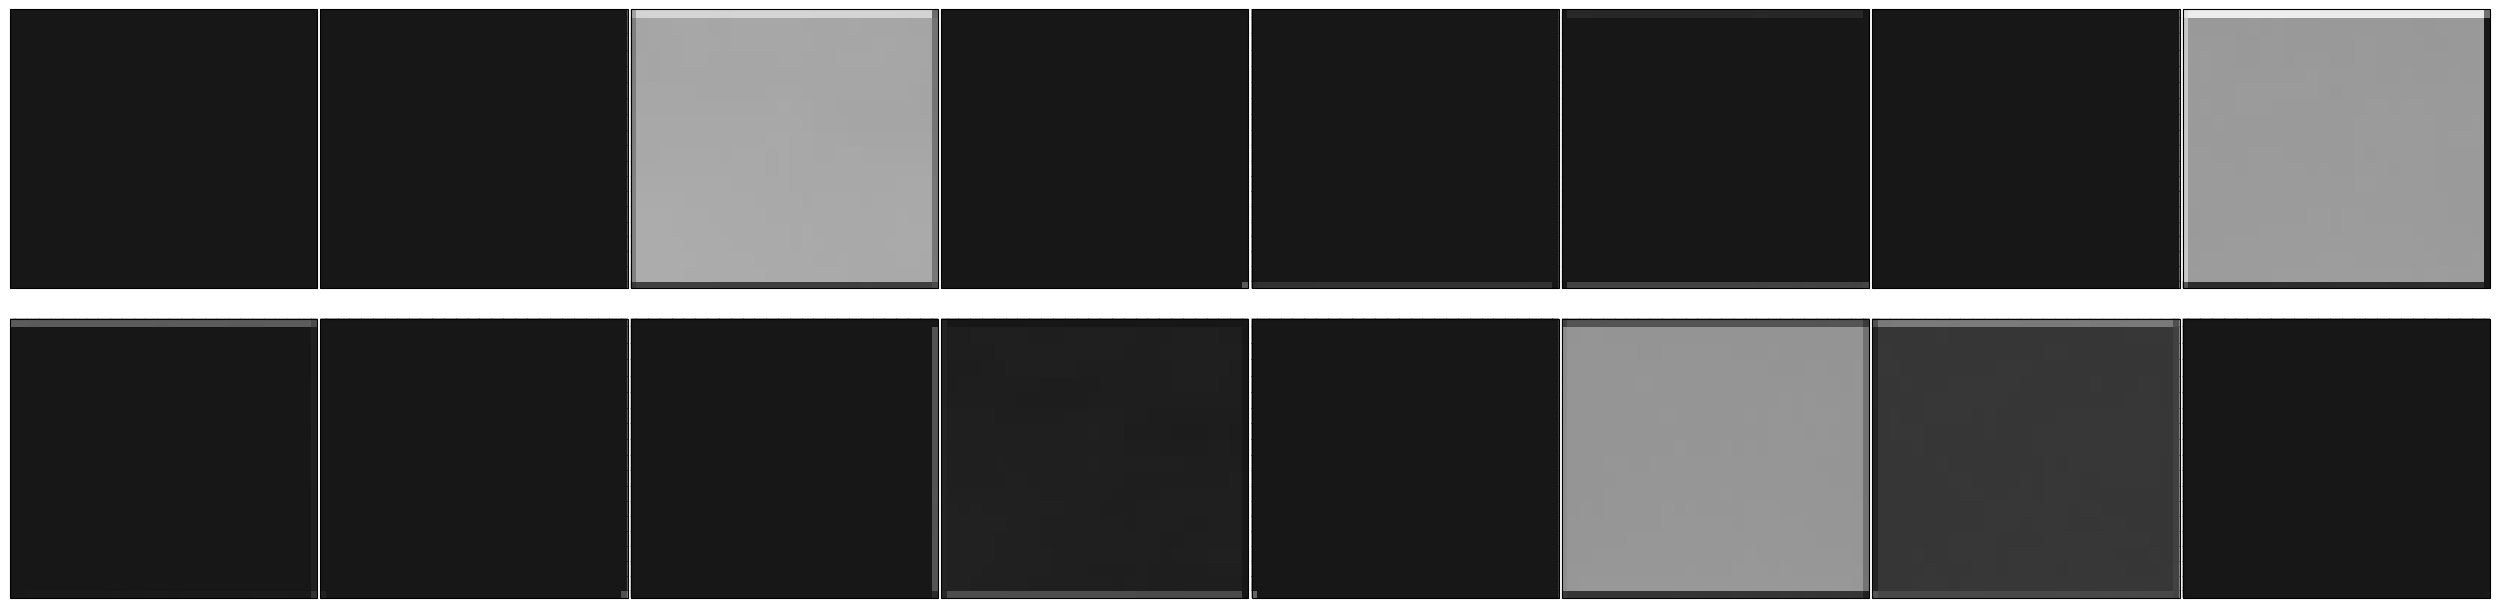

-0.7474324
[36.    37.125 38.25  39.375 40.5   41.625 42.75  43.875 45.   ]


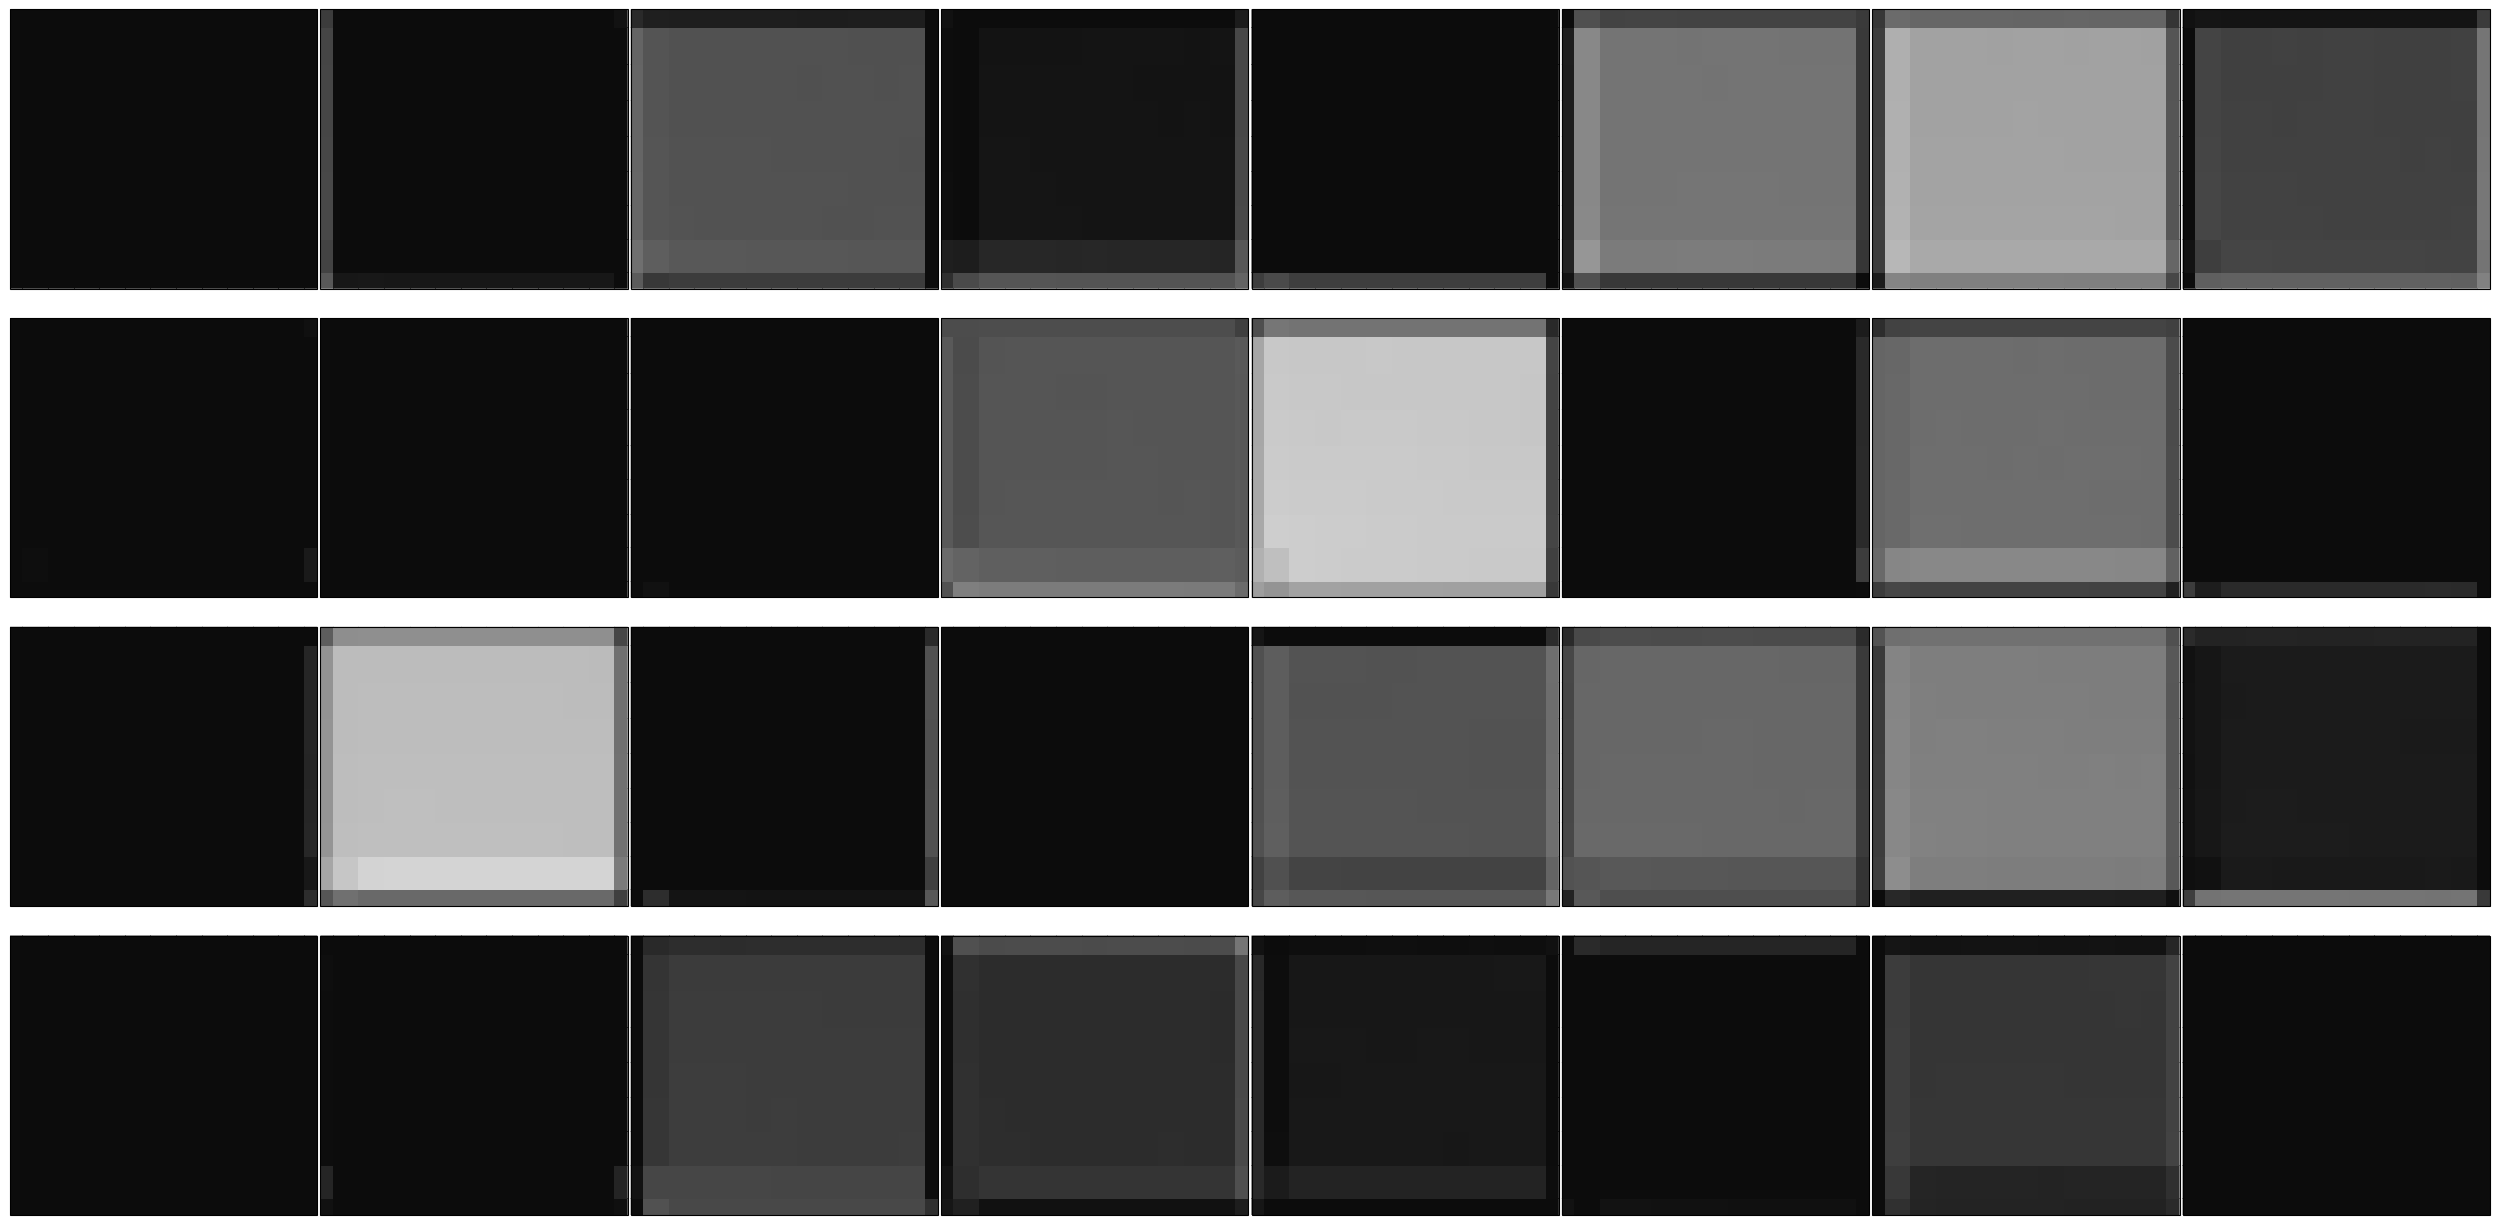

In [72]:
cmap_feat = ncm.cmap('NCV_blu_red')
extent = [-119, -106, 36, 45]

for lx in range(len(model.layers)):
    layer = model.layers[lx]
    if 'conv' not in layer.name:
        continue

    inputs = [atmos_subset[[0],:,:,:]]

    # Create a model that takes the input image and outputs the first
    # convolutional layer
    feat_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer.name).output])

    # Then compute the gradient of the top predicted class for our
    # input image with resepct to the activations of the layer
    LAYER = feat_model(inputs)
    LAYER = (LAYER - np.mean(LAYER)) / np.std(LAYER)

    print(np.min(LAYER))
    
    # pull plotting axis values
    lats = np.linspace(np.min(latitudes), np.max(latitudes), 
                       num=np.shape(LAYER)[1], endpoint=True)
    print(lats)
    lons = np.linspace(np.min(longitudes), np.max(longitudes), 
                       num=np.shape(LAYER)[2], endpoint=True)
    loni, lati = np.meshgrid(lons, lats)

    # find size of figure
    x_axis = 8
    y_axis = np.ceil(np.shape(LAYER)[3]/x_axis).astype('int')

    # Plot Transforms
    datacrs = ccrs.PlateCarree()
    projex = ccrs.Mercator(central_longitude=np.mean(lons))

    # new figure like michaels
    fig, ax = plt.subplots(nrows=y_axis, ncols=x_axis,
                           figsize=(x_axis*4, y_axis*4),
                           subplot_kw={'projection': projex})

    ax_count = 0
    for row in range(y_axis):
        for col in range(x_axis):
            if ax_count < np.shape(LAYER)[3]:
                # Add Feature Map                    
                ax[row, col].pcolor(loni, lati, np.squeeze(
                                LAYER[:, :, :, ax_count]), clim=[-1, 4],
                                zorder=1, cmap='gray', transform=datacrs)
                ax[row, col].set_extent(extent)

                
                ax_count += 1

            elif ax_count >= np.shape(LAYER)[3]:
                ax[row, col].axis('off')

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

In [19]:
# Remove the classification layer to get features
feature_extractor = tf.keras.models.Model(inputs=[model.input], outputs=[model.get_layer('conv2d_02').output])

# Get the features by passing the image through the network
features = feature_extractor.predict(atmos_subset)

print(np.shape(features))

# Plot the activations of the last convolutional layer
plt.figure(figsize=(10, 10))
for i in range(64):  # Assuming 64 filters in the last convolutional layer
    plt.subplot(8, 8, i+1)
    plt.imshow(features[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

ValueError: The layer sequential_2 has never been called and thus has no defined input.

### Grad-CAM

In [ ]:
dates = ["1996-02-18", "1996-02-23"]

In [ ]:
# Calculate Size of Data
atm_sz = dict(atmos.sizes)
opg_sz = dict(opg.sizes)
atmos_names = np.array(atmos.data_vars)
count_channels = 0
count_on_facet = 0
for ii in atmos.values():
    if len(ii.dims) == 3:
        count_channels += 1
    elif len(ii.dims) == 2:
        count_on_facet += 1
        atmos_names = np.delete(
            atmos_names, np.argmax(ii.name == atmos_names))

# pull plotting axis values
lons = np.array(atmos['lon'])
lats = np.array(atmos['lat'])
date = atmos['time']
loni, lati = np.meshgrid(lons, lats)

# find size of figure
x_axis = np.round(np.sqrt(count_channels+1)).astype('int')
y_axis = np.ceil(np.sqrt(count_channels+1)).astype('int')

# load regional location
rgn_bnds = opg.attrs['bounds']
rgn_lons = [rgn_bnds[2], rgn_bnds[2],
            rgn_bnds[3], rgn_bnds[3], rgn_bnds[2]]
rgn_lats = [rgn_bnds[0], rgn_bnds[1],
            rgn_bnds[1], rgn_bnds[0], rgn_bnds[0]]

# pull list of OPG values
opg_values = np.array(opg['opg'])

# Plot Presets
edges = [-15, 15]
step = 1.5
x_ticks = [-15, -10, -5, 0, 5, 10, 15]
x_tick_labels = ["", "-10", "", "0", "", "10", ""]
units = " (mm/km)"
max_count = 35
aspect = 0.6
shift = 1

# preset values
cmap_atmos = ncm.cmap('NCV_blu_red')

extent = [-150, -100, 25, 57.5]

# loop through each day
for dayx in range(0, atm_sz['time']):
    if np.sum(np.abs(opg_values[dayx, :] > 0)) > 0:
        # pull values from that day
        # Create Empty Array for Testing Data
        atmos_test_4D_X = np.zeros(
            (1, atm_sz['lat'], atm_sz['lon'], count_channels))
        atmos_test_OF_X = np.zeros((1, opg_sz['facet_num']*count_on_facet))

        # Pull Variables for Testing
        count_4D = 0
        count_OF = 0
        for var_name, values in atmos.items():
            if len(values.dims) == 3:
                atmos_test_4D_X[:, :, :, count_4D] = np.array(
                    values[dayx, :, :])
                count_4D += 1
            elif len(values.dims) == 2:
                atmos_test_OF_X[:, opg_sz['facet_num']*count_OF:opg_sz['facet_num']
                                * (count_OF+1)] = np.array(values[dayx, :])
                count_OF += 1

        # Combine Inputs if On-Facet Data Exists
        if count_on_facet > 0:
            inputs = [atmos_test_4D_X, atmos_test_OF_X]
        else:
            inputs = [atmos_test_4D_X]

        # SECOND ATTEMPT
        heatmap = []

        for output_node in range(opg_sz['facet_num']):
            # Create a model that takes the input image and outputs the last
            # convolutional layer and the output predictions
            grad_model = tf.keras.models.Model([model.inputs],
                                               [model.get_layer('conv2d_2').output, model.output])

            # Then compute the gradient of the top predicted class for our
            # input image with resepct to the activations of the last conv layer
            with tf.GradientTape() as tape:
                last_conv_layer_output, preds = grad_model(inputs)
                class_channel = preds[:, output_node]

            # This is the gradient of the output neuron with regard to the
            # output feature map of the last conv layer
            grads = tape.gradient(class_channel, last_conv_layer_output)

            # Formulates the mean gradient of each feature map, how important is each feature map?
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

            # Reduce to 3 dimentions
            last_conv_layer_output = last_conv_layer_output[0]

            # Multiply each channel of the feature map by how important it is
            heatmapx = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

            # Reduce dimentions
            heatmap.append(np.array(heatmapx))

        heatmap = np.concatenate(heatmap, axis=2)  # combine all maps
        heatmap = np.max(heatmap, axis=2) # create max of all maps
        # create percentile of all maps
        # heatmap = np.percentile(heatmap, 90, axis=2)

        heatmap = heatmap / np.max(heatmap[:])  # Scale to max of 1
        heatmap[heatmap < 0] = 0  # Remove all the negative values

        # interpolate the heatmap grid
        heatmap_size = np.shape(heatmap)
        heatmap_lat = np.linspace(
            np.min(lats), np.max(lats), num=heatmap_size[0])
        heatmap_lon = np.linspace(
            np.min(lons), np.max(lons), num=heatmap_size[1])
        h_lon, h_lat = np.meshgrid(heatmap_lon, heatmap_lat)

        # pull atmosphere
        atmos_data = np.squeeze(inputs[0])

        ###### plot heatmap   ##################################
        datacrs = ccrs.PlateCarree()
        projex = ccrs.Mercator(central_longitude=np.mean(lons))
        chnnl = 0

        # create predicted values, convert values of non-units to mm/km
        pred = model.predict(inputs)
        if opg_type == 1:
            pred = pp_cnn.standardized_to_raw(pred, opg) * 1000
        elif opg_type == 2:
            pred = pp_cnn.normalized_to_raw(pred, opg) * 1000

        # new figure like michaels
        fig, ax = plt.subplots(nrows=y_axis, ncols=x_axis,
                               figsize=(x_axis*4, y_axis*4),
                               subplot_kw={'projection': projex})

        ax_count = 1
        for row in range(y_axis):
            for col in range(x_axis):

                if ax_count == 1:
                    # Calc Error
                    if opg_type == 0:
                        error = (opg_values[dayx, :] - pred[0, :]) * 1000
                    else:
                        idx = opg_values[dayx, :] != 0
                        error = (opg_values[dayx, idx] - pred[0, idx])

                    me = np.mean(error)

                    # Plot Histogram

                    lower = np.sum(error < edges[0])
                    upper = np.sum(error > edges[1])
                    n, bins, patches = ax[row, col].hist(error,
                                                         bins=np.arange(
                                                             edges[0]-step, edges[1]+step+step, step),
                                                         edgecolor="white")
                    ax[row, col].set(xlim=(edges[0]-step, edges[1]+step),
                                     ylim=(0, max_count),
                                     xticks=x_ticks,
                                     xticklabels=x_tick_labels,
                                     yticks=range(0, max_count+1, 10))

                    # Add Outliers
                    patches[0].set_height(patches[0].get_height() + lower)
                    patches[0].set_facecolor('k')
                    patches[-1].set_height(patches[-1].get_height() + upper)
                    patches[-1].set_facecolor('k')

                    # Plot mean error
                    ax[row, col].plot([me, me], [0, 80], c='red')
                    if me > 0:
                        ax[row, col].text(me-shift, max_count-8,
                                          "Mean Error:"+"\n" +
                                          str(np.round(me, decimals=2))+units,
                                          c='red', fontsize=12, horizontalalignment='right')
                    else:
                        ax[row, col].text(me+shift, max_count-8,
                                          "Mean Error:"+"\n" +
                                          str(np.round(me, decimals=2))+units,
                                          c='red', fontsize=12, horizontalalignment='left')

                    # Plot settings
                    ax[row, col].set_aspect(aspect)
                    ax[row, col].set_title("OPG Prediction Error",
                                           fontsize=14, weight='bold')
                    ax[row, col].grid(True)
                    ax[row, col].set_ylabel("Count of Facets", fontsize=12)
                    ax[row, col].set_xlabel("Error"+units, fontsize=12)
                    ax[row, col].tick_params(labelsize=12)

                elif ax_count > (count_channels+1):
                    ax[row, col].axis('off')

                else:

                    # Add Z-Scored Atmospheric Data
                    atmos_plot = ax[row, col].contourf(loni, lati,
                                                        np.squeeze(
                                                            atmos_data[:, :, chnnl]),
                                                        cmap=cmap_atmos,
                                                        zorder=1,
                                                        levels=np.arange(-6, 6.5, 0.5),
                                                        transform=datacrs, extend='both')

                    # Cartography Features
                    states_provinces = cfeat.NaturalEarthFeature(
                                            category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m', facecolor='none')
                    ax[row, col].add_feature(cfeat.COASTLINE.with_scale(
                        '110m'), zorder=2, edgecolor="saddlebrown")
                    ax[row, col].add_feature(cfeat.BORDERS.with_scale(
                        '110m'), zorder=3, edgecolor="saddlebrown")
                    ax[row, col].add_feature(states_provinces, 
                                 zorder=4, edgecolor="saddlebrown")
                    ax[row, col].set_extent(extent)

                    # Add Regional Location
                    ax[row, col].plot(rgn_lons, rgn_lats, linewidth=2,
                                      c='black', zorder=5, transform=datacrs)

                    # Add importance of the atmos data and layer over
                    hx = heatmap.copy()*100
                    hatch = ax[row, col].contourf(h_lon, h_lat, hx, colors='none',
                                          zorder=6, transform=datacrs,
                                          hatches=[None, '..', 'oo','OO'], 
                                          levels=[0, 25, 50, 75, 100])

                    # Add Title
                    ax[row, col].set_title(rename_title(atmos_names[chnnl]),
                                           fontsize=14,
                                           weight='bold')

                    # Add To Channel Count Value
                    chnnl += 1

                ax_count += 1

        # Adjust Spacing
        #plt.subplots_adjust(wspace=0.25, hspace=0.25)
        
        # Add percentage that are above 80%
        prct = str(np.round((np.sum(heatmap > 0.50) / heatmap.size)*100, decimals=1))
        fig.supxlabel(f"{prct}% of Domain is >50%", x=0.93, y=0.09, horizontalalignment="right")
        
        # Add Colorbar for Atmos
        cbar_atmos = fig.add_axes([0.93, 0.35, 0.03, 0.55])
        cb_at = fig.colorbar(atmos_plot, cax=cbar_atmos, ticks=np.arange(-6,8,2),
                              pad=0.0, aspect=15, fraction=0.032)
        cb_at.set_label('Z-Score of Atmospheric Data', size=16)
        cb_at.ax.tick_params(labelsize=16)

        # Add Colorbar for Hatching
        cbar_cam = fig.add_axes([0.93, 0.12, 0.03, 0.2])
        cb_cam = fig.colorbar(hatch, cax=cbar_cam,
                              pad=0.0, aspect=15, fraction=0.032)
        cb_cam.set_label("Max. Grad-CAM (%)", size=16)
        cb_cam.ax.tick_params(labelsize=16)
        
        # Add Title with Date and Actual/Predicted Values
        df = np.array(date[dayx], dtype='str')
        df = str(df)
        plt.suptitle(df[0:10], fontsize=18, y=0.93, weight='bold')

        # create path to save
        path = save_dir + "activ_map/"
        if os.path.exists(path) == False:
            os.mkdir(path)

        plt.savefig(path + df[0:10] + "_" + name + ".png", dpi=400, transparent=True,
                    bbox_inches='tight')

        plt.close()
        
        # Show Figure
        # plt.show()

### Downscaling